In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [42]:
# MLflow setting
import mlflow

mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment('nyc-taxi-experiment')

<Experiment: artifact_location='mlflow-artifacts:/937530806142134978', creation_time=1716308952433, experiment_id='937530806142134978', last_update_time=1716308952433, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

### Load yellow taxi data
[NY taxi dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [43]:
# Read parquets and do some transformations
def read_data_frame(filename):
    df = pd.read_parquet(filename)
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime)
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df['duration'] > 0) & (df['duration'] < 120) & (df['passenger_count'].notna())]

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    
    df[categorical] = df[categorical].astype(str)
    return df

In [44]:
# Prepare train and valdiation data

df_train = read_data_frame('../data/yellow_tripdata_2024-01.parquet')
df_val = read_data_frame('../data/yellow_tripdata_2024-02.parquet')

len(df_train), len(df_val)

(2820972, 2818415)

In [45]:
# Just describe dataset
df_train.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    2.820972e+06
mean     1.474504e+01
std      1.177543e+01
min      1.666667e-02
50%      1.150000e+01
95%      3.796667e+01
98%      5.070000e+01
99%      5.960000e+01
max      1.199667e+02
Name: duration, dtype: float64

/tmp/nix-shell.9Gh3Nb/ipykernel_32310/1764197534.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration)
/tmp/nix-shell.9Gh3Nb/ipykernel_32310/1764197534.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_val.duration)


<Axes: xlabel='duration', ylabel='Density'>

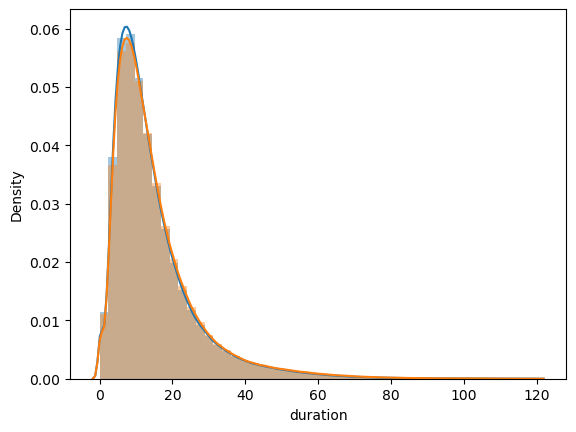

In [46]:
sns.distplot(df_train.duration)
sns.distplot(df_val.duration)

In [47]:
df_train.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
duration                        float64
dtype: object

In [48]:
# Hyperparam tunning
df_train['PU_DO'] = df_train['PULocationID'] + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + df_val['DOLocationID']

In [49]:
# *** Train model - Linear regression ***

categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

# Feature matrix for my model training
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# Feature matrix for my model training
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Training part
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

# Prediction part
y_predict = lr.predict(X_val)

# Evaluation part
mean_squared_error(y_val, y_predict, squared=False)




/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.928124492990459

In [50]:
# Save the model - we'll use this model for entire course
import pickle

with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

mlflow.log_artifact(local_path='../models/lin_reg.bin', artifact_path='models_pickle|')

/tmp/nix-shell.9Gh3Nb/ipykernel_32310/7925631.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_predict, label='prediction')
/tmp/nix-shell.9Gh3Nb/ipykernel_32310/7925631.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


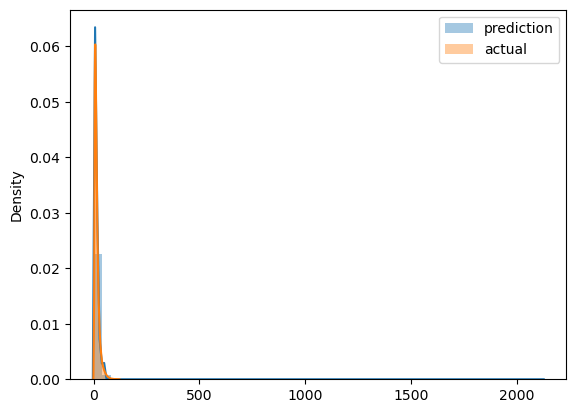

In [51]:
# Plot is somehow weird, maybe we need to do more data cleaning?
sns.distplot(y_predict, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

## Try to use Laso reggresion

In [12]:
from sklearn.linear_model import Lasso

In [29]:
with mlflow.start_run():

    mlflow.set_tag('developer', 'jacob')

    mlflow.log_param('train-data-path', '../data/yellow_tripdata_2024-01.parquet')
    mlflow.log_param('valid-data-path', '../data/yellow_tripdata_2024-02.parquet')
    
    # *** Train model - Lasso regression ***

    alpha = 0.1
    mlflow.log_param('alpha', alpha)
    
    categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    
    dv = DictVectorizer()
    
    # Feature matrix for my model training
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)
    
    # Feature matrix for my model training
    val_dicts = df_val[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dicts)
    
    # Training part
    target = 'duration'
    y_train = df_train[target].values
    y_val = df_val[target].values
    
    lr_lasso = Lasso(alpha)
    lr_lasso.fit(X_train, y_train)
    
    # Prediction part
    y_predict = lr_lasso.predict(X_val)
    
    # Evaluation part
    rmse = mean_squared_error(y_val, y_predict, squared=False)
    mlflow.log_metric('rmse', rmse)

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MlflowException: Invalid artifact path: 'models_pickle/'. Names may be treated as files in certain cases, and must not resolve to other names when treated as such. This name would resolve to 'models_pickle'

# MLflow experiment with xgboost

Week 2 of MLOps zoomcamp experiment

In [32]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [33]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [34]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)
        return { 'loss': rmse, 'status': STATUS_OK }

In [40]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_slpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials())

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:36:08] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.49067                           
[1]	validation-rmse:6.58707                           
[2]	validation-rmse:6.39896                           
[3]	validation-rmse:6.34327                           
[4]	validation-rmse:6.32257                           
[5]	validation-rmse:6.31404                           
[6]	validation-rmse:6.30803                           
[7]	validation-rmse:6.30270                           
[8]	validation-rmse:6.29873                           
[9]	validation-rmse:6.29531                           
[10]	validation-rmse:6.29124                          
[11]	validation-rmse:6.28573                          
[12]	validation-rmse:6.28181                          
[13]	validation-rmse:6.27876                          
[14]	validation-rmse:6.27565                          
[15]	validation-rmse:6.26784                          
[16]	validation-rmse:6.26453                          
[17]	validation-rmse:6.26150                          
[18]	valid

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:07] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.55874                                                       
[1]	validation-rmse:8.13358                                                       
[2]	validation-rmse:7.38299                                                       
[3]	validation-rmse:6.99661                                                       
[4]	validation-rmse:6.79747                                                       
[5]	validation-rmse:6.68996                                                       
[6]	validation-rmse:6.63087                                                       
[7]	validation-rmse:6.59434                                                       
[8]	validation-rmse:6.57157                                                       
[9]	validation-rmse:6.55537                                                       
[10]	validation-rmse:6.54698                                                      
[11]	validation-rmse:6.53953                                                      
[12]

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:43:12] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20767                                                      
[1]	validation-rmse:10.42286                                                      
[2]	validation-rmse:9.75194                                                       
[3]	validation-rmse:9.18134                                                       
[4]	validation-rmse:8.69828                                                       
[5]	validation-rmse:8.29139                                                       
[6]	validation-rmse:7.94879                                                       
[7]	validation-rmse:7.66274                                                       
[8]	validation-rmse:7.42427                                                       
[9]	validation-rmse:7.22622                                                       
[10]	validation-rmse:7.06187                                                      
[11]	validation-rmse:6.92443                                                      
[12]

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:47:30] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.12462                                                      
[1]	validation-rmse:10.28320                                                      
[2]	validation-rmse:9.57744                                                       
[3]	validation-rmse:8.98878                                                       
[4]	validation-rmse:8.50117                                                       
[5]	validation-rmse:8.09674                                                       
[6]	validation-rmse:7.76579                                                       
[7]	validation-rmse:7.49606                                                       
[8]	validation-rmse:7.27521                                                       
[9]	validation-rmse:7.09513                                                       
[10]	validation-rmse:6.95001                                                      
[11]	validation-rmse:6.83171                                                      
[12]

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:51:18] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.94848                                                      
[1]	validation-rmse:9.99293                                                       
[2]	validation-rmse:9.22039                                                       
[3]	validation-rmse:8.60163                                                       
[4]	validation-rmse:8.10932                                                       
[5]	validation-rmse:7.72100                                                       
[6]	validation-rmse:7.41592                                                       
[7]	validation-rmse:7.17659                                                       
[8]	validation-rmse:6.99043                                                       
[9]	validation-rmse:6.84492                                                       
[10]	validation-rmse:6.73061                                                      
[11]	validation-rmse:6.64027                                                      
[12]

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:55:05] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.90094                                                      
[1]	validation-rmse:9.91374                                                       
[2]	validation-rmse:9.12122                                                       
[3]	validation-rmse:8.48808                                                       
[4]	validation-rmse:7.99246                                                       
[5]	validation-rmse:7.60393                                                       
[6]	validation-rmse:7.30063                                                       
[7]	validation-rmse:7.06408                                                       
[8]	validation-rmse:6.88315                                                       
[9]	validation-rmse:6.73997                                                       
[10]	validation-rmse:6.63271                                                      
[11]	validation-rmse:6.54424                                                      
[12]

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:00:16] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.27638                                                      
[1]	validation-rmse:10.54281                                                      
[2]	validation-rmse:9.90896                                                       
[3]	validation-rmse:9.36261                                                       
[4]	validation-rmse:8.89487                                                       
[5]	validation-rmse:8.49568                                                       
[6]	validation-rmse:8.15622                                                       
[7]	validation-rmse:7.86922                                                       
[8]	validation-rmse:7.62441                                                       
[9]	validation-rmse:7.41765                                                       
[10]	validation-rmse:7.24271                                                      
[11]	validation-rmse:7.09686                                                      
[12]

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:04:44] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.76479                                                       
[1]	validation-rmse:6.65155                                                       
[2]	validation-rmse:6.36969                                                       
[3]	validation-rmse:6.27984                                                       
[4]	validation-rmse:6.24336                                                       
[5]	validation-rmse:6.22455                                                       
[6]	validation-rmse:6.21509                                                       
[7]	validation-rmse:6.20942                                                       
[8]	validation-rmse:6.20549                                                       
[9]	validation-rmse:6.20159                                                       
[10]	validation-rmse:6.19792                                                      
[11]	validation-rmse:6.19450                                                      
[12]

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:09:19] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.48874                                                      
[1]	validation-rmse:9.28996                                                       
[2]	validation-rmse:8.42535                                                       
[3]	validation-rmse:7.81199                                                       
[4]	validation-rmse:7.38295                                                       
[5]	validation-rmse:7.08323                                                       
[6]	validation-rmse:6.87636                                                       
[7]	validation-rmse:6.73111                                                       
[8]	validation-rmse:6.62969                                                       
[9]	validation-rmse:6.55566                                                       
[10]	validation-rmse:6.50329                                                      
[11]	validation-rmse:6.46530                                                      
[12]

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:14:53] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.76929                                                      
[1]	validation-rmse:9.70387                                                       
[2]	validation-rmse:8.87419                                                       
[3]	validation-rmse:8.23557                                                       
[4]	validation-rmse:7.74775                                                       
[5]	validation-rmse:7.38008                                                       
[6]	validation-rmse:7.10284                                                       
[7]	validation-rmse:6.89424                                                       
[8]	validation-rmse:6.73866                                                       
[9]	validation-rmse:6.62123                                                       
[10]	validation-rmse:6.53255                                                      
[11]	validation-rmse:6.46497                                                      
[12]

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:18:52] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.79169                                                       
[1]	validation-rmse:9.75063                                                        
[2]	validation-rmse:8.94442                                                        
[3]	validation-rmse:8.32630                                                        
[4]	validation-rmse:7.85915                                                        
[5]	validation-rmse:7.50654                                                        
[6]	validation-rmse:7.24235                                                        
[7]	validation-rmse:7.04699                                                        
[8]	validation-rmse:6.89871                                                        
[9]	validation-rmse:6.78893                                                        
[10]	validation-rmse:6.70637                                                       
[11]	validation-rmse:6.64277                                                

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:21:53] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.36081                                                       
[1]	validation-rmse:9.08416                                                        
[2]	validation-rmse:8.17719                                                        
[3]	validation-rmse:7.54476                                                        
[4]	validation-rmse:7.11043                                                        
[5]	validation-rmse:6.81441                                                        
[6]	validation-rmse:6.61300                                                        
[7]	validation-rmse:6.47585                                                        
[8]	validation-rmse:6.38222                                                        
[9]	validation-rmse:6.31627                                                        
[10]	validation-rmse:6.26707                                                       
[11]	validation-rmse:6.23204                                                

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:26:57] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.43467                                                       
[1]	validation-rmse:6.45174                                                       
[2]	validation-rmse:6.24287                                                       
[3]	validation-rmse:6.18096                                                       
[4]	validation-rmse:6.15161                                                       
[5]	validation-rmse:6.13968                                                       
[6]	validation-rmse:6.13280                                                       
[7]	validation-rmse:6.12830                                                       
[8]	validation-rmse:6.12418                                                       
[9]	validation-rmse:6.11566                                                       
[10]	validation-rmse:6.11206                                                      
[11]	validation-rmse:6.10817                                                      
[12]

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:31:21] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.98979                                                        
[1]	validation-rmse:8.60329                                                        
[2]	validation-rmse:7.72911                                                        
[3]	validation-rmse:7.19486                                                        
[4]	validation-rmse:6.86998                                                        
[5]	validation-rmse:6.67003                                                        
[6]	validation-rmse:6.54574                                                        
[7]	validation-rmse:6.46795                                                        
[8]	validation-rmse:6.41717                                                        
[9]	validation-rmse:6.38219                                                        
[10]	validation-rmse:6.35635                                                       
[11]	validation-rmse:6.33909                                                

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:34:42] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.08457                                                       
[1]	validation-rmse:10.21317                                                       
[2]	validation-rmse:9.48540                                                        
[3]	validation-rmse:8.88100                                                        
[4]	validation-rmse:8.38245                                                        
[5]	validation-rmse:7.97383                                                        
[6]	validation-rmse:7.63987                                                        
[7]	validation-rmse:7.36889                                                        
[8]	validation-rmse:7.14928                                                        
[9]	validation-rmse:6.97199                                                        
[10]	validation-rmse:6.82869                                                       
[11]	validation-rmse:6.71293                                                

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:39:07] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.82196                                                          
[1]	validation-rmse:6.77468                                                          
[2]	validation-rmse:6.52399                                                          
[3]	validation-rmse:6.44379                                                          
[4]	validation-rmse:6.41170                                                          
[5]	validation-rmse:6.39662                                                          
[6]	validation-rmse:6.39064                                                          
[7]	validation-rmse:6.37970                                                          
[8]	validation-rmse:6.37534                                                          
[9]	validation-rmse:6.37121                                                          
[10]	validation-rmse:6.36165                                                         
[11]	validation-rmse:6.35788                          

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:00:29] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.43410                                                         
[1]	validation-rmse:10.82067                                                         
[2]	validation-rmse:10.27448                                                         
[3]	validation-rmse:9.78949                                                          
[4]	validation-rmse:9.35977                                                          
[5]	validation-rmse:8.98048                                                          
[6]	validation-rmse:8.64632                                                          
[7]	validation-rmse:8.35299                                                          
[8]	validation-rmse:8.09598                                                          
[9]	validation-rmse:7.87005                                                          
[10]	validation-rmse:7.67305                                                         
[11]	validation-rmse:7.50169                          

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:06:20] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.65298                                                          
[1]	validation-rmse:6.60068                                                          
[2]	validation-rmse:6.35616                                                          
[3]	validation-rmse:6.28301                                                          
[4]	validation-rmse:6.25315                                                          
[5]	validation-rmse:6.24074                                                          
[6]	validation-rmse:6.23598                                                          
[7]	validation-rmse:6.23181                                                          
[8]	validation-rmse:6.22672                                                          
[9]	validation-rmse:6.22314                                                          
[10]	validation-rmse:6.21786                                                         
[11]	validation-rmse:6.21286                          

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:11:51] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.13009                                                          
[1]	validation-rmse:6.81164                                                          
[2]	validation-rmse:6.40888                                                          
[3]	validation-rmse:6.26990                                                          
[4]	validation-rmse:6.21293                                                          
[5]	validation-rmse:6.18433                                                          
[6]	validation-rmse:6.16493                                                          
[7]	validation-rmse:6.15570                                                          
[8]	validation-rmse:6.15111                                                          
[9]	validation-rmse:6.14627                                                          
[10]	validation-rmse:6.14288                                                         
[11]	validation-rmse:6.13953                          

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:39:23] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.39562                                                              
[1]	validation-rmse:7.95992                                                              
[2]	validation-rmse:7.24823                                                              
[3]	validation-rmse:6.90249                                                              
[4]	validation-rmse:6.73124                                                              
[5]	validation-rmse:6.64284                                                              
[6]	validation-rmse:6.59360                                                              
[7]	validation-rmse:6.56461                                                              
[8]	validation-rmse:6.54781                                                              
[9]	validation-rmse:6.53427                                                              
[10]	validation-rmse:6.52413                                                             
[11]	valid

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:43:30] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.33804                                                             
[1]	validation-rmse:6.26050                                                             
[2]	validation-rmse:6.25141                                                             
[3]	validation-rmse:6.24311                                                             
[4]	validation-rmse:6.23505                                                             
[5]	validation-rmse:6.22748                                                             
[6]	validation-rmse:6.21930                                                             
[7]	validation-rmse:6.21163                                                             
[8]	validation-rmse:6.20430                                                             
[9]	validation-rmse:6.19783                                                             
[10]	validation-rmse:6.19105                                                            
[11]	validation-rmse:

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:49:08] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.29290                                                             
[1]	validation-rmse:6.20603                                                             
[2]	validation-rmse:6.19384                                                             
[3]	validation-rmse:6.18500                                                             
[4]	validation-rmse:6.17592                                                             
[5]	validation-rmse:6.16893                                                             
[6]	validation-rmse:6.16147                                                             
[7]	validation-rmse:6.15532                                                             
[8]	validation-rmse:6.15034                                                             
[9]	validation-rmse:6.13593                                                             
[10]	validation-rmse:6.13035                                                            
[11]	validation-rmse:

/nix/store/kvpg58s66ywi60yw53h79zvfhlcbpnc0-python3.11-scikit-learn-1.4.2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/nix/store/zmjah4xc5hp41c41cbrbk1ac7b922pjx-python3.11-xgboost-2.0.3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [08:58:03] WARNING: /build/source/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.41155                                                             
[1]	validation-rmse:6.19961                                                             
[2]	validation-rmse:6.17039                                                             
[3]	validation-rmse:6.16058                                                             
[4]	validation-rmse:6.15299                                                             
[5]	validation-rmse:6.14571                                                             
[6]	validation-rmse:6.14015                                                             
 44%|████▍     | 22/50 [11:23:08<14:29:27, 1863.13s/trial, best loss: 5.985863451148275]


KeyboardInterrupt: 